![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [6]:
# Celda 1 - Funciones para implementar el árbol de decisión manualmente.

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split
    
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [8]:
#Estimación del modelo con las muestras de entrenamiento. Se escoge el valor de max_depth de manera arbitraria.  
tree_ = tree_grow(X_train,y_train, max_depth = 5)

y_predict = tree_predict(X_test, tree_ ) #Predicción en la muesra de prueba (test) 

#Se calcula el Accuracy del modelo con la variable de respuesta de prueba. 
print('El Accuracy del modelo con un max_depth arbitrario de 5 es: ' + str(metrics.accuracy_score(y_predict, y_test))) 

El Accuracy del modelo con un max_depth arbitrario de 5 es: 0.8879907621247113


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [18]:
# Celda 2

from sklearn.tree import DecisionTreeClassifier #Importar librerias

# Creación de 10 muestras de bootstrap 
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Definición del modelo usando DecisionTreeRegressor de sklearn con un valor para max_depth de 5.
treereg = DecisionTreeClassifier(max_depth= 5, random_state=1)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    Xtrain = X_train.iloc[sample, :]
    ytrain = y_train.iloc[sample]
    treereg.fit(Xtrain, ytrain)
    y_pred.iloc[:,i] = treereg.predict(X_test)

for i in range(n_B):
    print('Árbol ', i, 'tiene un accuracy de: ', metrics.accuracy_score(y_pred.iloc[:,i].astype(int), y_test) )

print('\n')

#Para realizar los ensambles de las estimadores bootstraped se usara votación mayoritaria. 
yvotacionmayoritaria = (y_pred.sum(axis=1) >= 5).astype(int)
print('El Accuracy del modelo ensamblado es: ' + str(metrics.accuracy_score(yvotacionmayoritaria, y_test)))

Árbol  0 tiene un accuracy de:  0.8853926096997691
Árbol  1 tiene un accuracy de:  0.8853926096997691
Árbol  2 tiene un accuracy de:  0.8643187066974596
Árbol  3 tiene un accuracy de:  0.8810623556581986
Árbol  4 tiene un accuracy de:  0.8836605080831409
Árbol  5 tiene un accuracy de:  0.8767321016166282
Árbol  6 tiene un accuracy de:  0.8761547344110855
Árbol  7 tiene un accuracy de:  0.8827944572748267
Árbol  8 tiene un accuracy de:  0.8620092378752887
Árbol  9 tiene un accuracy de:  0.878175519630485


El Accuracy del modelo ensamblado es: 0.8862586605080831


El desempeño del modelo ensamblado es ligeramente mayor al desempeño de todos los modelos individuales. Sin embargo, es ligeramente menor al modelo que se implementó manualmente. 

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [19]:
# Celda 3
from sklearn.ensemble import BaggingClassifier #Importar librerias
#El parametro max_features se establece como el ln(Número de predictores). Nuevamente, escogemos arbitrariamente un max_depth de 5. 
bagreg = BaggingClassifier( DecisionTreeClassifier(max_features = round(np.log(X_train.shape[1]) ), max_depth=5) , n_estimators=10,
                          bootstrap=True, oob_score=True, random_state=1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred_ = bagreg.predict(X_test)
y_pred_

# Cálculo del desempeño del modelo 
print('El Accuracy del modelo Bagging con libreria es: ' + str(metrics.accuracy_score(y_test, y_pred_)))

El Accuracy del modelo Bagging con libreria es: 0.8822170900692841


En general, todos los modelos estimados tienen un desempeño similar, sin embargo, el desempeño del modelo de bagging de 10 árboles con librería es ligeramente menor al desempeño del árbol manual y el del ensamblaje manual.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [64]:
# Celda 41
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#Random forest parametros por default
clf = RandomForestClassifier()
clf.fit(X_train, y_train) #Entrenamiento del modelo 

y_rf_predict = clf.predict(X_test) #Prediccion en muestra de prueba

print(metrics.accuracy_score(y_rf_predict,y_test)) #Accuracy del modelo en el set de prueba


0.8432448036951501


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

**Calibración del parametro n_estimadores: El número de estimadores (árboles) a crear en el random forest para luego ser promediados.**

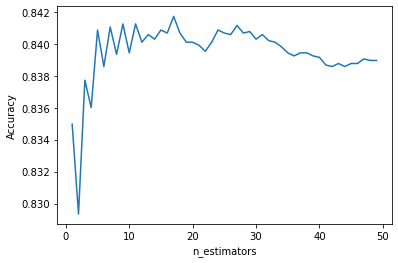



El numero de estimadores que maximiza el Accuracy es: 17


In [54]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(1, 50, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()
print('\n')
print('El numero de estimadores que maximiza el Accuracy es: '+ str(np.argmax(accuracy_scores)+1) )



**Calibración del parametro max_features: El número de columnas a considerar en cada bifurcación de los arboles del random forest.**

El numero de estimadores que maximiza el Accuracy es: 8




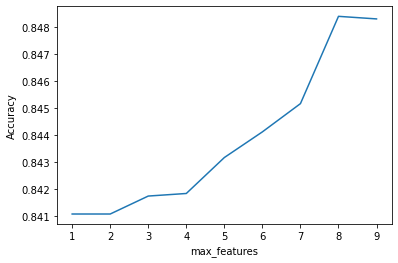

In [57]:
# Celda 6
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=17, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

    # Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
print('El numero de estimadores que maximiza el Accuracy es: '+ str(np.argmax(accuracy_scores)+1) )
print('\n')
plt.show()

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [62]:
# Importación y definición de modelo XGBClassifier
from xgboost import XGBClassifier
clf = XGBClassifier()

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)

y_pred_xgb = clf.predict(X_test)

print('\n')
print('El Accuracy del modelo XGBoost con los párametros por default: '+ str(metrics.accuracy_score(y_pred_xgb, y_test) ))


[19:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


El Accuracy del modelo XGBoost con los párametros por default: 0.8856812933025404


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
# Celda 7  




### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
